In [4]:
import numpy as np
from qpsolvers import solve_qp
from scipy.integrate import solve_ivp
from scipy.linalg import pinv2
from tqdm import tqdm



In [5]:
from casadi import *
import casadi
from torch import nn
import torch
from matplotlib import pyplot as plt
import torch.nn.functional as F
from pyoselm import OSELMRegressor




In [4]:
## Non-affine
# dBe_hat(x, u) = pyOSELM_library(x, u), not possible using Casadi
# OSELM_byhand(x, u)


# beta(t) = sum(basis(t), beta_fixed)
# beta[n] = sum(basis[n], beta_fixed): n is time finite horizone. simTime = Finite

# basis -> inf for t -> inf : beta will diverge

# beta(t) = sum(basis(t), beta_fixed) 

# basis(t) = 


## Affine
# dBe_hat(x, u) = dBe_f_hat(x) + dBe_g_hat(x) u
# dBe_f(x)
# dS_real 
# dBe_hat(x, u) = [dBe_f_hat(x), dBe_g_hat(x) ] [1,u].T




# dBe_hat(x_(t), u) = [dBe_f_hat(x_(t)), dBe_g_hat(x_(t)) ] [1,u_t].T
# dBe_hat(x_(t-1), u) = [dBe_f_hat(x_(t-1)), dBe_g_hat(x_(t)) ] [1,u_(t-1)].T

# dBe_hat(x, u) = [dBe_fg_hat(x)] [ue].T
# dBe_hat(x, u) pinv([ue].T) = [dBe_fg_hat(x)]

# 
# 

#########


# prediction_casadi: dS_hat(x, u) = dB(x, u) + dBe_hat(x, u) : Matrix multiplation ELM ---> NLP: opt u
# prediction: dS_hat = dB(x, k) + dBe_hat(x, k) : Matrix multiplation ELM 
# training:  Loss (dBe_hat(x, k), dS_real - dB(x, k)) ----> Update weight ELM




In [6]:
class OSELM:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
                
        self.w_ik = 1*np.random.randn(input_dim,hidden_dim)
        self.P = np.zeros((self.hidden_dim, self.hidden_dim))
        self.Omega = np.zeros((self.hidden_dim, self.output_dim))
        

    def predict(self, x, data_points = 1):
        
        H = []

        for n in range(data_points):   
            h = []
            for k in range(self.hidden_dim):
                g = []
                for i in range(self.input_dim):
                    g.append(x[n,i]* self.w_ik[i,k])
                g = sigmoid(np.sum(g))
                h.append(g) 
            h = np.array(h)
            H.append(h)

        H = np.array(H)
        
        y = np.matmul(H, self.Omega)
        
        return y, H
        
    def predict_casadi(self,x):
        def sigmoid_casadi(x):
            return 1 / (1 + casadi.exp(-x))
        y = 0 
        #print("TTTTTTTTTTT")
        for k in range(self.hidden_dim):
            g = 0
            for i in range(self.input_dim):
                g += (x[0,i]* self.w_ik[i,k])

            g = sigmoid_casadi(g)
            y += self.Omega[k,0]*g
        #print("RRRRRRRR")
        #print(self.Omega)
        #print("SSSSSSSSSSSS")
        return y        
        
    def training_first(self, xs, ys):
        
        if xs.ndim > 2:
            xs = xs.squeeze()
        
        data_points, _ = np.shape(xs)
        #print(data_points)

        _, H = self.predict(xs, data_points)
                
        # Calculate P0 and T0
        self.P = pinv2(np.matmul(H.T, H))
       
        self.Omega = np.matmul(self.P, np.matmul(H.T, ys))

    def training(self,x, y):
        _, H = self.predict(x.T)
        #print("tttttt")
        #print("H")
        #print(type(H))
        #print("P")
        #print(type(self.P))
        #print("y")
        #print(y)
        #print(np.matmul(H, self.Omega))
        self.P = self.P - np.matmul(self.P, np.matmul(H.T, np.matmul(H, self.P))) / (1 + (np.matmul(H, np.matmul(self.P,H.T))))
        #print(self.Omega)
        self.Omega = self.Omega + np.matmul( self.P, np.matmul(H.T, y - np.matmul(H, self.Omega)))
        #print(2)
        #print(self.Omega)
        
        
        #print(x)
        #print(u_num)
        #print("ffffff")

    def get_P(self):
        return self.P
    
    def get_Omega(self):
        return self.Omega
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [7]:
c, h = elm.predict(np.array([[1,2,3]])) 

NameError: name 'elm' is not defined

In [ ]:
elm = OSELM(3,100,2)
elm.training_first(np.random.randn(200,3), np.random.randn(200,2) )

array([[0., 0.]])

In [14]:
class AAC:
    def __init__(self, m, c_d, f0, f1, f2, v_ego):
        self.m = m
        self.c_d = c_d
        self.f0 = f0
        self.f1 = f1
        self.f2 = f2
        self.v_ego = v_ego
        self.u = 0
        
        
    def update(self, x0, u, t, dt):
        
        x = MX.sym('x',3) # Three states
        
        p = x[0]
        v = x[1]
        z = x[2]
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2
        
        f = vertcat(
            v,
            -1/self.m*Fr,
            self.v_ego - v           
        )
        g = vertcat([
            0,
            1/self.m *u,
            0
        ])
        

        dx = f + g
        
        ode = {}         # ODE declaration
        ode['x']   = x   # states
        ode['ode'] = dx # right-hand side 

        # Construct a Function that integrates over 4s
        F = integrator('F','cvodes',ode,{'t0':t,'tf':t+dt})

        res = F(x0=x0)
        
        x_n = res['xf'].elements()
        
        return np.expand_dims(np.array(x_n), axis = 1)
        
        

In [8]:
class LQPCBFCLF:
    def __init__(self, m_nom, ca_nom, cd_nom, f0_nom, f1_nom, f2_nom, v_ego_nom, v_des, Th, clf_rate, cbf_rate, p_slack):
        self.m = m_nom
        self.ca = ca_nom
        self.cd = cd_nom
        self.f0 = f0_nom
        self.f1 = f1_nom
        self.f2 = f2_nom
        self.v_ego = v_ego_nom 
        self.v_des = v_des
        self.Th = Th
        
        self.p_slack = p_slack
        self.cbf_rate = cbf_rate
        self.clf_rate = clf_rate
        
        
    def clf(self, symb_x):
        v = symb_x[1,0]        

        clf = (v - self.v_des)**2;
        return clf
        
    def cbf(self, symb_x):
        v = symb_x[1,0]
        z = symb_x[2,0]

        cbf = z - self.Th * v - 0.5  * (self.v_ego - v)**2 / (self.cd * 9.81);
        return cbf
        

    def dcbf(self, x, u):
        v = x[1]
        z = x[2]
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2

        dB = 1/self.m * (self.Th + (v - self.v_ego)/self.cd/9.81 ) * (Fr - u) + (self.v_ego - v)
        
        return dB
        
    def compute_controller(self, x, u_ref, estimator, weights, is_collecting):
        v = x[1,0]
        z = x[2,0]

        u = SX.sym('u')
        slack = SX.sym('slack')
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2
        
        V = self.clf(x)
        dV = (v - self.v_des)*(2/self.m*(u - u_ref))

        B = self.cbf(x);
        dB = 1/self.m * (self.Th + (v - self.v_ego)/self.cd/9.81 ) * (Fr - u) + (self.v_ego - v)
        
       
        if is_collecting:
            S = dB
            dBe_est = 0
            
        else:
            dBe_est, _ = estimator.predict(x.T)
            S = dB + dBe_est[0,0] + u*dBe_est[0,1] 
        
        weight_input = 2/self.m**2
        
        fqp = (u_ref - u)**2 * weight_input + self.p_slack * slack**2
        gqp = vertcat( -dV - self.clf_rate*V + slack, S + self.cbf_rate * B)
        
        # Optimization
        qp = {'x': vertcat(u,slack), 'f':fqp, 'g':gqp}
        
        S = nlpsol('S', 'ipopt', qp,{'verbose':False,'print_time':False, "ipopt": {"print_level": 0}})
             
        r = S(lbg=0, lbx = -m*self.cd*g, ubx = m*self.ca*g)
        
        k = r['x'].elements()[0]
        slack_sol = r['x'].elements()[1]
        
        if is_collecting:
            dBe_est_num = 0  
        else:
            o, _ = estimator.predict(x.T)
            dBe_est_num = o[0,0] + k*o[0,1] 
        
        dB_num = 1/self.m * (self.Th + (v - self.v_ego)/self.cd/9.81 ) * (Fr - k) + (self.v_ego - v)
        
        return dBe_est_num, k, slack_sol, V, B, dB_num

In [9]:
def sample_initial_state(p_min = 0, p_max = 2,
                         v_min = 18, v_max = 22,
                         z_min = 38, z_max = 42):
    p0 = np.random.uniform(p_min, p_max)
    v0 = np.random.uniform(v_min, v_max)
    z0 = np.random.uniform(z_min, z_max)
    return np.array([[p0], [v0], [z0]])

class Derivator:
    def __init__(self, dt):
        self.x = 0
        self.dt = dt
        
    def update(self, x_n):
        dx = (x_n - self.x)/dt
        
        self.x = x_n
        
        
        return dx
    

# Different cases

In [17]:
dt = 0.01
simTime = 20

# Real parameters
v_ego = 26
v_des = 24
m  = 1650.0
g = 9.81

# 
f0 = 0.1
f1 = 5
f2 = 0.25
#

c_a = 0.3
c_d = 0.3
Th = 1.8

# Nominal parameters
f0_nom = 10*f0
f1_nom = 10*f1
f2_nom = 10*f2

p_slack = 2e-2
clf_rate = 5
cbf_rate = 5.

# Initial state
p0 = 0.
v0 = 22
z0 = 40


x_lst = []
u_lst = []
V_lst = []
B_lst = []
slack_lst = []

# Parameter ELM
n_hidden = 100



In [71]:
print(x)

[[ 0]
 [20]
 [40]]


In [18]:
aac = AAC(m, c_d, f0, f1, f2, v_ego)

cont = LQPCBFCLF(m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_ego, v_des, Th, clf_rate, cbf_rate, p_slack)
learned_ratio = 1.6

derivator = Derivator(dt)

elm = OSELM(3, n_hidden, 2)

xs = []
us = []
Vs = []
Bs = []
dBes_hat = []
dBes = []

slacks = []

weights = 0.2

train_input, train_output = [], []

x = np.array([[p0], [v0] ,[z0]])

first_time = True



if simTime / dt < learned_ratio*n_hidden:
    raise Error('simTime / dT: {} must be larger than {} times the n_hidden: {}'.format(simTime / dT, learned_ratio,n_hidden))

pbar = tqdm(total=simTime/dt)
for t in np.arange(0, simTime, dt): #simTime
    pbar.update(n=1)
    
    # Get Fr
    v = x[1]
    Fr = f0_nom * v**2 + f1_nom * v + f2_nom
    
    aac.v_ego = v_ego + 5*np.sin(2*t)
    cont.v_ego =  v_ego + 5*np.sin(2*t)
    
    
    if t / dt < n_hidden:
        # Control Input
        dBe_est_num, k, slack_sol, V, B, dB_num = cont.compute_controller(x, Fr, _, weights, True)        
    else:
        dBe_est_num, k, slack_sol, V, B, dB_num = cont.compute_controller(x, Fr, elm, weights, False)
        
        
    #B_perf = x[2] - Th * x[1] - 0.5  * (v_ego - x[1])**2 / (c_d * 9.81)

    # One step propagation in the system
    x_n = aac.update(x, k, t, dt)

    dB_real = derivator.update(B)
    
    if t / dt < learned_ratio*n_hidden:
        train_input.append(x)
        dS = dB_real - dB_num
        train_output.append([dS/(1+k*k), k*dS/(1+k*k)])
    else :
        if first_time:            
            elm.training_first(np.array(train_input), np.array(train_output))
            first_time = False
        else:
            dS = dB_real - dB_num
            elm.training(x, np.array([[dS/(1+k*k), k*dS/(1+k*k)]]))



    xs.append(x)
    us.append(k)
    Vs.append(V)
    Bs.append(B)
    slacks.append(slack_sol)
    dBes.append(dB_real - dB_num)
    dBes_hat.append(dBe_est_num)


    x = x_n
        
pbar.close()


 52%|█████▏    | 1045/2000.0 [00:40<01:03, 14.95it/s]/home/emanuelsamir/.local/lib/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: overflow encountered in exp
100%|██████████| 2000/2000.0 [01:36<00:00, 20.79it/s]


In [155]:
n_hidden*learned_ratio*dt

1.6

(-10.0, 10.0)

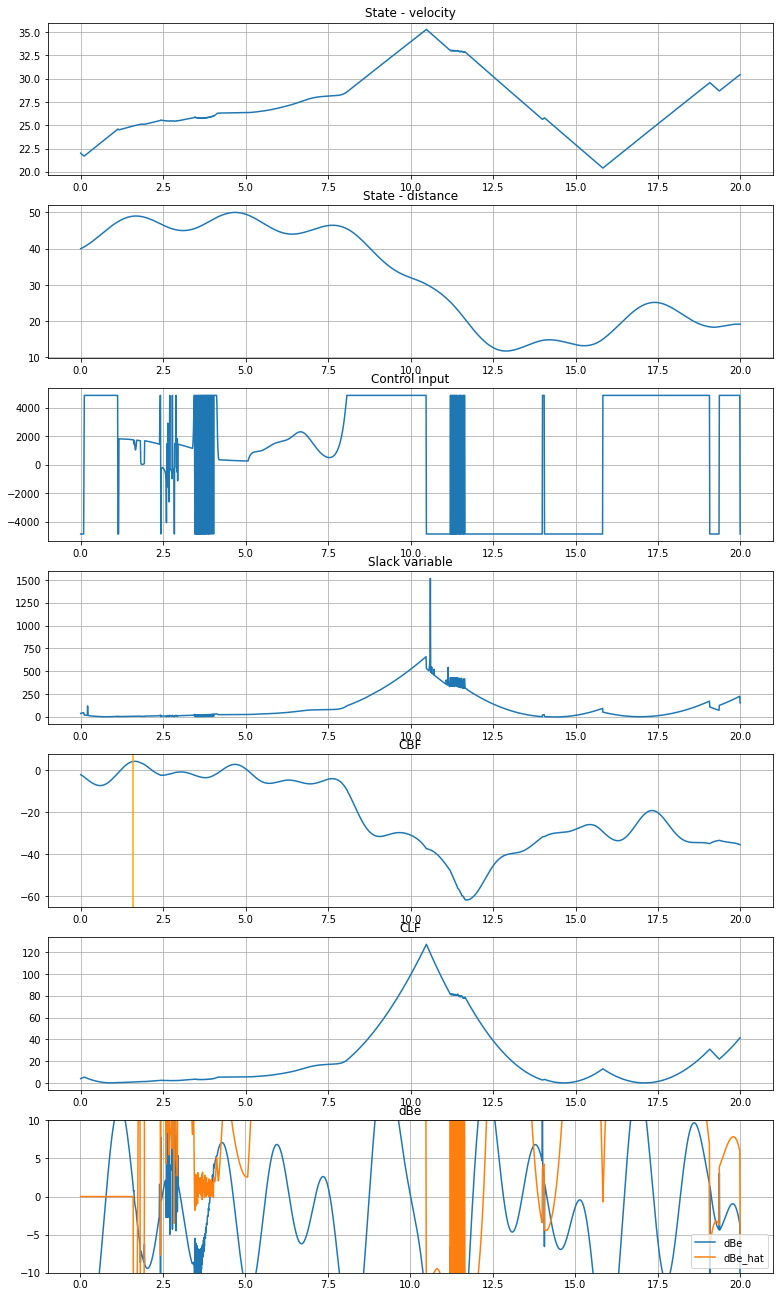

In [19]:
f,ax = plt.subplots(7,1,figsize = (13,23))
t_lns = np.arange(0, simTime, dt)
exp = 1


ax[0].plot(t_lns, np.array(xs)[:,1])
ax[0].grid(True)
ax[0].set_title('State - velocity')

ax[1].plot(t_lns,  np.array(xs)[:,2])
ax[1].grid(True)
ax[1].set_title('State - distance')

#ax[1].plot(t_lns, Th*np.array(x_lst)[exp,:,1])#  + 0.5*(np.array(x_lst)[exp,:,1] - v_ego)/c_d/g)

ax[2].plot(t_lns,  np.array(us))
ax[2].grid(True)
ax[2].set_title('Control input')

ax[3].plot(t_lns, np.array(slacks))
ax[3].grid(True)
ax[3].set_title('Slack variable')

ax[4].plot(t_lns, Bs)
ax[4].axvline(x = n_hidden*learned_ratio*dt, color = 'orange')
ax[4].grid(True)
ax[4].set_title('CBF')

ax[5].plot(t_lns, Vs)
ax[5].grid(True)
ax[5].set_title('CLF')

ax[6].plot(t_lns[1:], dBes[1:])
ax[6].plot(t_lns[1:], np.squeeze(dBes_hat)[1:])
ax[6].grid(True)
ax[6].set_title('dBe')

ax[6].legend(['dBe', "dBe_hat"])
ax[6].set_ylim([-10,10])


In [21]:
train_input

[array([[ 0.],
        [22.],
        [40.]]),
 array([[ 0.21984804],
        [21.96960935],
        [40.04015196]]),
 array([[ 0.43939158],
        [21.93922043],
        [40.08160836]]),
 array([[ 0.65863067],
        [21.90883325],
        [40.12436873]]),
 array([[ 0.87756537],
        [21.8784478 ],
        [40.16843223]]),
 array([[ 1.09619637],
        [21.84806407],
        [40.21379696]]),
 array([[ 1.31452317],
        [21.81768207],
        [40.26046183]]),
 array([[ 1.5325458 ],
        [21.7873018 ],
        [40.30842482]]),
 array([[ 1.75026428],
        [21.75692325],
        [40.3576835 ]]),
 array([[ 1.96767863],
        [21.72654642],
        [40.40823505]]),
 array([[ 2.18478887],
        [21.69617132],
        [40.46007629]]),
 array([[ 2.40174422],
        [21.69516324],
        [40.51305441]]),
 array([[ 2.61884233],
        [21.7236482 ],
        [40.56686778]]),
 array([[ 2.83622565],
        [21.75213155],
        [40.62136959]]),
 array([[ 3.05389413],
       

In [20]:
train_output

[[-1.007422428841105e-05, 0.048919929433309646],
 [-6.023063307831814e-07, 0.0029247694269665895],
 [-6.191997537047417e-07, 0.00300680304400254],
 [-6.358263008215272e-07, 0.0030875407254742954],
 [-6.521582976520812e-07, 0.003166848085483624],
 [-6.68171253819517e-07, 0.003244606199984884],
 [-6.838328263044197e-07, 0.003320658012892947],
 [-6.991184213461438e-07, 0.003394884098135807],
 [-7.140015616216329e-07, 0.0034671558831565687],
 [-7.284559199309221e-07, 0.003537345524388561],
 [-0.15629111038610008, 1.6467459044388264],
 [-7.605733475729151e-07, -0.003693306147146697],
 [-7.648017437500926e-07, -0.003713839027563262],
 [-7.697929899884142e-07, -0.0037380762697342396],
 [-7.74311702291035e-07, -0.0037600189107401517],
 [-7.783444549564932e-07, -0.0037796017560459833],
 [-7.818783600571857e-07, -0.0037967622225196906],
 [-7.849010411048332e-07, -0.003811440210553015],
 [-7.874007096973508e-07, -0.003823578476254851],
 [-7.893661911107527e-07, -0.0038331227557242597],
 [-7.90786

In [319]:
d = Dataset()
T = 10   # Number of experiences

aac = AAC(m, c_d, f0, f1, f2, v_ego)

cont = LQPCBFCLF(0.8*m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_ego, v_des, Th, clf_rate, cbf_rate, p_slack)


n_hidden = 60
estimator = OSELMRegressor(n_hidden=n_hidden, activation_func='sigmoid', random_state=123)


weights = 0.2

x_lst = []
u_lst = []
V_lst = []
B_lst = []
B_perf_lst = []
slack_lst = []


dBe_lst = []


x_initial = []
y_initial = []


x0 = sample_initial_state()
x = x0
derivator = Derivator(dt)

pbar = tqdm(total=T)


for _ in range(T):
    x0 = sample_initial_state()
    x = x0
    derivator = Derivator(dt)
    
    xs = []
    us = []
    Vs = []
    Bs = []
    B_perfs = []
    slacks = []
    b_hs = []
    a_hs = []
    
    for t in np.arange(0, simTime, dt): #simTime
        # Get Fr
        v = x[1]
        Fr = f0_nom * v**2 + f1_nom * v + f2_nom

        # Control Input
        dBe_est, k, slack_sol, V, B, db_hat = cont.compute_controller(x, Fr, estimator, weights)
        
        B_perf = x[2] - Th * x[1] - 0.5  * (v_ego - x[1])**2 / (c_d * 9.81)

        # One step propagation in the system
        x_n = aac.update(x, k, t, dt)
        
        db = derivator.update(B)
        
        d.update(x, k, db, db_hat)
        
        xs.append(x)
        us.append(k)
        Vs.append(V)
        Bs.append(B)
        slacks.append(slack_sol)
        a_hs.append(a_h)
        b_hs.append(b_h)
        B_perfs.append(B_perf)
        
        x = x_n
        
        
    # Save data
    x_lst.append(xs)
    u_lst.append(us)
    V_lst.append(Vs)
    B_lst.append(Bs)
    slack_lst.append(slacks)
    a_h_lst.append(a_hs)
    b_h_lst.append(b_hs)
    B_perf_lst.append(B_perfs)

    # Train estimator
    sample = d.get_D()
        
    for x_i, k_i, dh_i, dh_hat_i in zip(sample.x, sample.k, sample.dh, sample.dh_hat ):
        S_i = A_h.forward(x_i, train = True) + B_h.forward(x_i, train = True)*k_i + cont.dcbf(x_i, k_i) # dh_hat_i
        
        Loss = F.mse_loss(torch.tensor(dh_i),S_i)

        A_h.model.zero_grad()
        B_h.model.zero_grad()

        Loss.backward()
        A_h_opt.step()
        B_h_opt.step()
    
        
        



NameError: name 'Dataset' is not defined

### No training

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

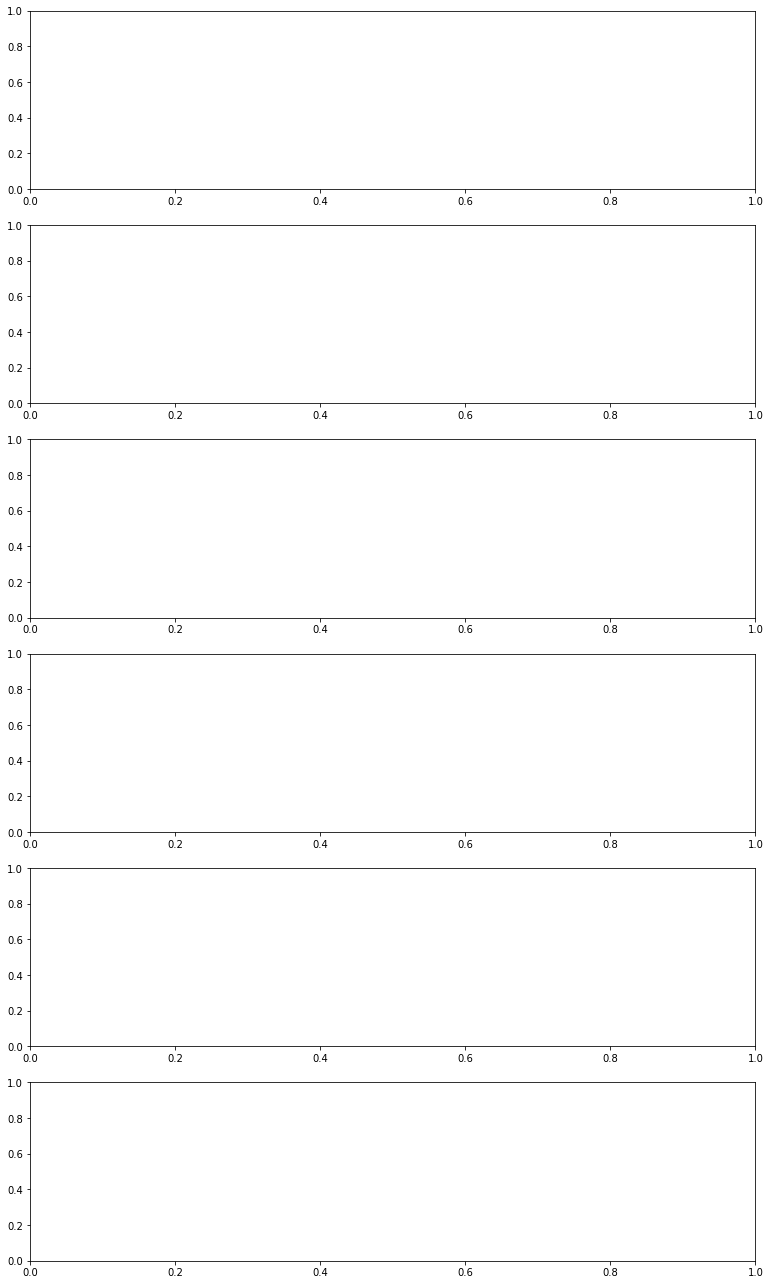

In [87]:
f,ax = plt.subplots(6,1,figsize = (13,23))
t_lns = np.arange(0, 10, dt)
exp = 1


ax[0].plot(t_lns, np.array(x_lst)[exp,:,1])
ax[0].grid(True)
ax[0].set_title('State - velocity')

ax[1].plot(t_lns, np.array(x_lst)[exp,:,2])
ax[1].grid(True)
ax[1].set_title('State - distance')

ax[1].plot(t_lns, Th*np.array(x_lst)[exp,:,1])#  + 0.5*(np.array(x_lst)[exp,:,1] - v_ego)/c_d/g)

ax[2].plot(t_lns, np.array(u_lst)[exp,:])
ax[2].grid(True)
ax[2].set_title('Control input')

ax[3].plot(t_lns, np.array(slack_lst)[exp,:])
ax[3].grid(True)
ax[3].set_title('Slack variable')

ax[4].plot(t_lns, np.array(B_lst)[exp,:])
ax[4].grid(True)
ax[4].set_title('CBF')

ax[5].plot(t_lns, np.array(V_lst)[exp,:])
ax[5].grid(True)
ax[5].set_title('CLF')


In [21]:
t_lns.shape

(500,)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

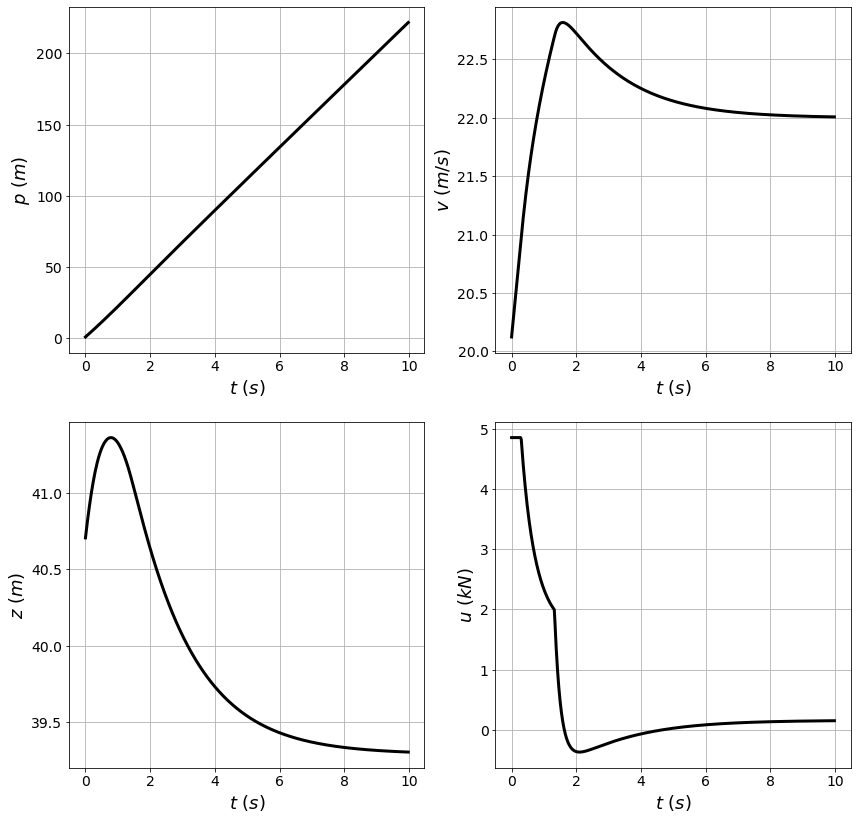

In [100]:
f,ax = plt.subplots(2,2,figsize = (14,14))
t_lns = np.arange(0, 10, dt)
exp = 9

ax[0,0].plot(t_lns, np.array(x_lst)[exp,:,0], 'k', linewidth = 3)
ax[0,0].grid(True)
ax[0,0].set_ylabel('$p$ $(m)$', fontsize = 18)
ax[0,0].set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0,0].set_title('State - position')

ax[0,1].plot(t_lns, np.array(x_lst)[exp,:,1], 'k', linewidth = 3)
ax[0,1].grid(True)
ax[0,1].set_ylabel('$v$ $(m/s)$', fontsize = 18)
ax[0,1].set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0,1].set_title('State - velocity')

ax[1,0].plot(t_lns, np.array(x_lst)[exp,:,2],'k', linewidth = 3)
ax[1,0].grid(True)
ax[1,0].set_ylabel('$z$ $(m)$', fontsize = 18)
ax[1,0].set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[1,0].set_title('State - distance')

ax[1,1].plot(t_lns, np.array(u_lst)[exp,:]/1000, 'k', linewidth = 3)
ax[1,1].grid(True)
ax[1,1].set_ylabel('$u$ $(kN)$', fontsize = 18)
ax[1,1].set_xlabel('$t$ $(s)$', fontsize = 18)
#ax[1,1].tick_params(fontsize=14)
plt.yticks(fontsize=14)
plt.setp(ax[0,0].get_xticklabels(), fontsize=14)
plt.setp(ax[0,0].get_yticklabels(), fontsize=14)

plt.setp(ax[0,1].get_xticklabels(), fontsize=14)
plt.setp(ax[0,1].get_yticklabels(), fontsize=14)

plt.setp(ax[1,0].get_xticklabels(), fontsize=14) 
plt.setp(ax[1,0].get_yticklabels(), fontsize=14)



plt.setp(ax[1,1].get_xticklabels(), fontsize=14)
plt.setp(ax[1,1].get_yticklabels(), fontsize=14)


#ax[1,1].set_title('State - distance')

(array([-50.,   0.,  50., 100., 150., 200., 250.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

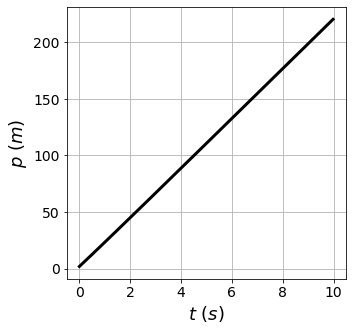

In [122]:
f,ax = plt.subplots(1,1,figsize = (5,5))
t_lns = np.arange(0, 10, dt)
exp = 9

ax.plot(t_lns, np.array(x_lst)[exp,:,0], 'k', linewidth = 3)
ax.grid(True)
ax.set_ylabel('$p$ $(m)$', fontsize = 18)
ax.set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0,0].set_title('State - position')

(array([18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

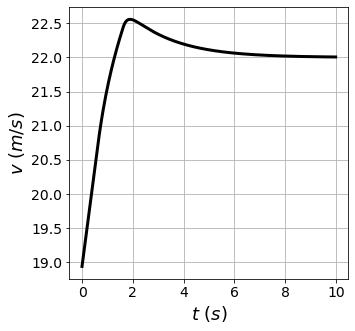

In [121]:
f,ax = plt.subplots(1,1,figsize = (5,5))
t_lns = np.arange(0, 10, dt)
exp = 8

ax.plot(t_lns, np.array(x_lst)[exp,:,1], 'k', linewidth = 3)
ax.grid(True)
ax.set_ylabel('$v$ $(m/s)$', fontsize = 18)
ax.set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0,0].set_title('State - position')

(array([39.  , 39.25, 39.5 , 39.75, 40.  , 40.25, 40.5 , 40.75, 41.  ,
        41.25]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

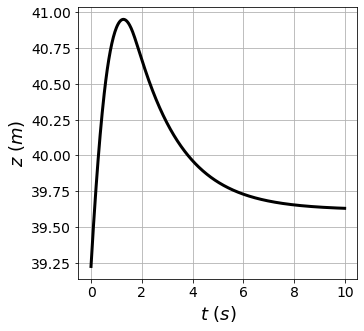

In [123]:
f,ax = plt.subplots(1,1,figsize = (5,5))
t_lns = np.arange(0, 10, dt)
exp = 8

ax.plot(t_lns, np.array(x_lst)[exp,:,2], 'k', linewidth = 3)
ax.grid(True)
ax.set_ylabel('$z$ $(m)$', fontsize = 18)
ax.set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

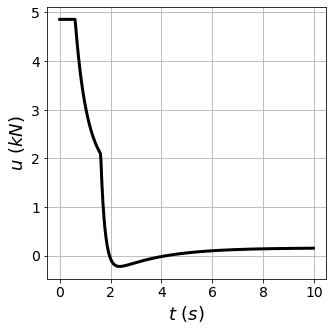

In [120]:
f,ax = plt.subplots(1,1,figsize = (5,5))
t_lns = np.arange(0, 10, dt)
exp = 8

ax.plot(t_lns, np.array(u_lst)[exp,:]/1000, 'k', linewidth = 3)
ax.grid(True)
ax.set_ylabel('$u$ $(kN)$', fontsize = 18)
ax.set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

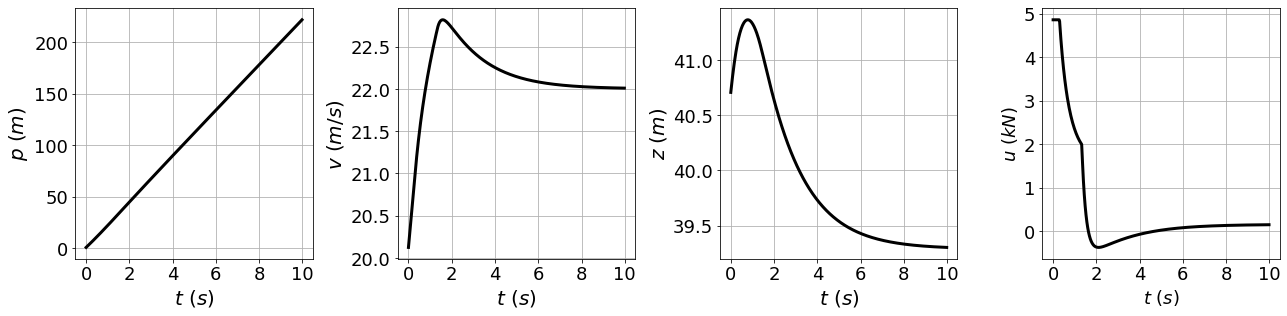

In [99]:
f,ax = plt.subplots(1,4,figsize = (18,4.5))
t_lns = np.arange(0, 10, dt)
exp = 0

ax[0].plot(t_lns, np.array(x_lst)[exp,:,0], 'k', linewidth = 3)
ax[0].grid(True)
ax[0].set_ylabel('$p$ $(m)$', fontsize = 20)
ax[0].set_xlabel('$t$ $(s)$', fontsize = 20)

ax[1].plot(t_lns, np.array(x_lst)[exp,:,1], 'k', linewidth = 3)
ax[1].grid(True)
ax[1].set_ylabel('$v$ $(m/s)$', fontsize = 20)
ax[1].set_xlabel('$t$ $(s)$', fontsize = 20)


ax[2].plot(t_lns, np.array(x_lst)[exp,:,2],'k', linewidth = 3)
ax[2].grid(True)
ax[2].set_ylabel('$z$ $(m)$', fontsize = 20)
ax[2].set_xlabel('$t$ $(s)$', fontsize = 20)

ax[3].plot(t_lns, np.array(u_lst)[exp,:]/1000, 'k', linewidth = 3)
ax[3].grid(True)
ax[3].set_ylabel('$u$ $(kN)$', fontsize = 18)
ax[3].set_xlabel('$t$ $(s)$', fontsize = 18)



plt.setp(ax[0].get_xticklabels(), fontsize=18)
plt.setp(ax[0].get_yticklabels(), fontsize=18)

plt.setp(ax[1].get_xticklabels(), fontsize=18)
plt.setp(ax[1].get_yticklabels(), fontsize=18)

plt.setp(ax[2].get_xticklabels(), fontsize=18) 
plt.setp(ax[2].get_yticklabels(), fontsize=18)

plt.setp(ax[3].get_xticklabels(), fontsize=18)
plt.setp(ax[3].get_yticklabels(), fontsize=18)

f.tight_layout() 
#ax[1,1].set_title('State - distance')

### Barrier function

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

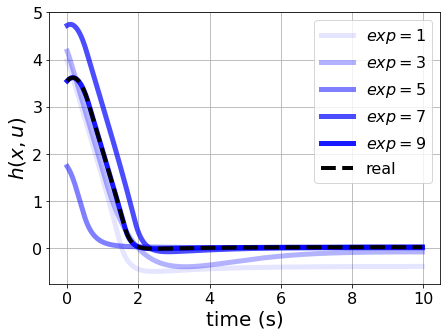

In [124]:
f,ax = plt.subplots(1,1,figsize = (7,5))
t_lns = np.arange(0, 10, dt)
exp = 8

start = 0



for exp in range(10):
    if exp % 2 == 0:
        h = np.array(x_lst)[exp,start:,2] - Th*np.array(x_lst)[exp,start:,1]  - 0.5*(np.array(x_lst)[exp,start:,1] - v_ego)/c_d/g
        h = np.array(B_lst)[exp,start:]
        ax.plot(t_lns[start:], h , 'blue', alpha = 0.1 * (exp + 1), linewidth = 5)
        #print(exp)
        
h_perf = np.array(B_lst)[exp,start:]
ax.plot(t_lns[start:], h,'black',linewidth = 4, linestyle = '--')

ax.grid(True)
#ax.set_title('Barrier function evolution in multiple experiences', fontsize= 18)
ax.legend(['$exp=1$','$exp=3$','$exp=5$','$exp=7$','$exp=9$','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 20)
ax.set_ylabel('$h(x, u)$', fontsize= 20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)



### Lyapunov function

Text(0, 0.5, '$V(x, u)$')

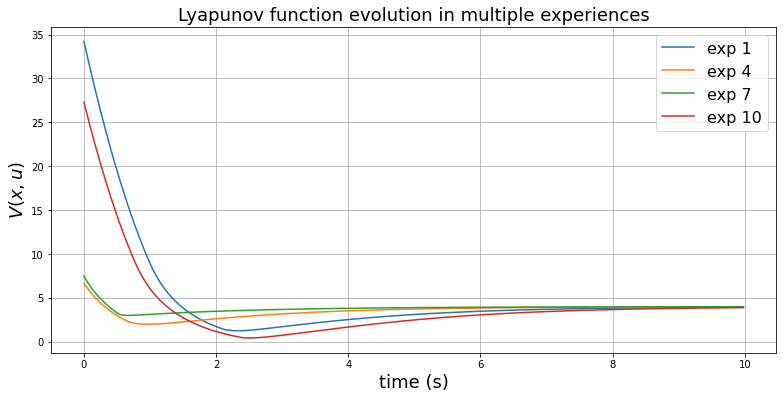

In [27]:
f,ax = plt.subplots(1,1,figsize = (13,6))
t_lns = np.arange(0, 10, dt)
exp = 8

start = 0

for exp in range(10):
    if exp % 3 == 0:
        V = np.array(V_lst)[exp,start:]
        ax.plot(t_lns[start:], V )
        #print(exp)
        
ax.grid(True)
ax.set_title('Lyapunov function evolution in multiple experiences', fontsize= 18)
ax.legend(['exp 1','exp 4','exp 7','exp 10'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$V(x, u)$', fontsize= 18)

### Comparison with perfect knowledge

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

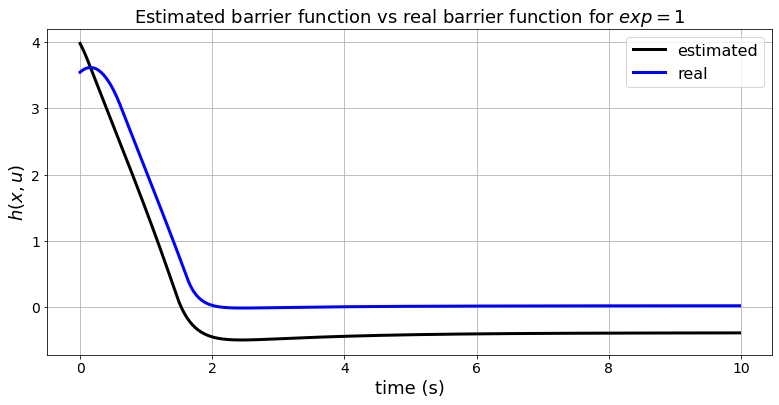

In [125]:
f,ax = plt.subplots(1,1,figsize = (13,6))
t_lns = np.arange(0, 10, dt)

start = 0
exp = 0

h_perf = np.array(B_perf_lst)[exp,start:]
ax.plot(t_lns[start:], h_perf, 'black',linewidth = 3 )

h_perf = np.array(B_lst)[exp,start:]
ax.plot(t_lns[start:], h,'blue',linewidth = 3)
#print(exp)
        
ax.grid(True)
ax.set_title('Estimated barrier function vs real barrier function for $exp = 1$', fontsize= 18)
ax.legend(['estimated','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$h(x, u)$', fontsize= 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

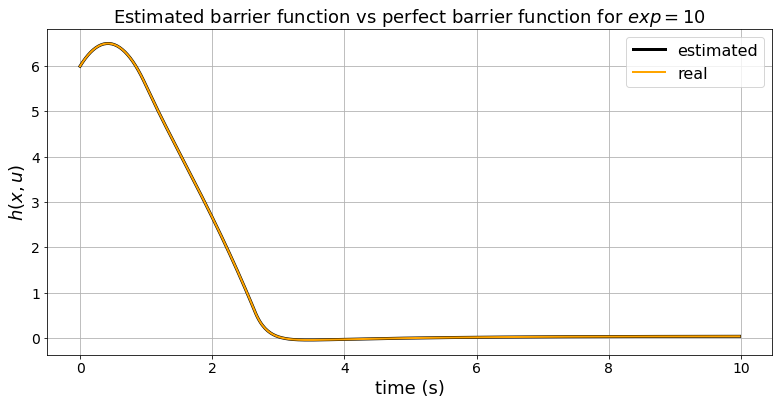

In [37]:
f,ax = plt.subplots(1,1,figsize = (13,6))
t_lns = np.arange(0, 10, dt)

start = 0
exp = 9

h_perf = np.array(B_perf_lst)[exp,start:]
ax.plot(t_lns[start:], h_perf, 'black',linewidth = 3 )

h_perf = np.array(B_lst)[exp,start:]
ax.plot(t_lns[start:], h,'orange',linewidth = 2)
#print(exp)
        
ax.grid(True)
ax.set_title('Estimated barrier function vs perfect barrier function for $exp = 10$', fontsize= 18)
ax.legend(['estimated','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$h(x, u)$', fontsize= 18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

### Estimator evolution

(array([-2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

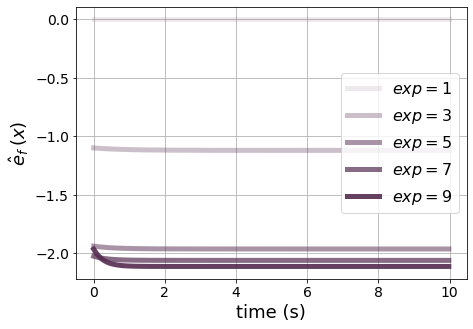

In [126]:
f,ax = plt.subplots(1,1,figsize = (7,5))
t_lns = np.arange(0, 10, dt)
exp = 8

start = 0

for exp in range(10):
    if exp % 2 == 0:
        V = np.array(a_h_lst)[exp,start:]
        ax.plot(t_lns[start:], V , color = (0.329, 0.168, 0.313), alpha = 0.1 * (exp + 1), linewidth = 5)
        #print(exp)
        
ax.grid(True)
#ax.set_title('Evolution of estimator $e_f$', fontsize= 18)
ax.legend(['$exp=1$','$exp=3$','$exp=5$','$exp=7$','$exp=9$','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$\hat{e}_f\:(x)$', fontsize= 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-0.003 , -0.0025, -0.002 , -0.0015, -0.001 , -0.0005,  0.    ,
         0.0005,  0.001 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

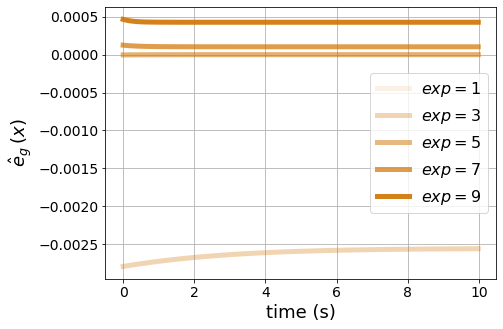

In [127]:
f,ax = plt.subplots(1,1,figsize = (7,5))
t_lns = np.arange(0, 10, dt)
exp = 8

start = 0

for exp in range(10):
    if exp % 2 == 0:
        V = np.array(b_h_lst)[exp,start:]
        ax.plot(t_lns[start:], V, color = (0.819, 0.450, 0), alpha = 0.1 * (exp + 1), linewidth = 5 )
        #print(exp) 
        
ax.grid(True)
#ax.set_title('Evolution of estimator $e_g$', fontsize= 18)
ax.legend(['$exp=1$','$exp=3$','$exp=5$','$exp=7$','$exp=9$','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$\hat{e}_g\:(x)$', fontsize= 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([35., 36., 37., 38., 39., 40., 41., 42., 43., 44.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

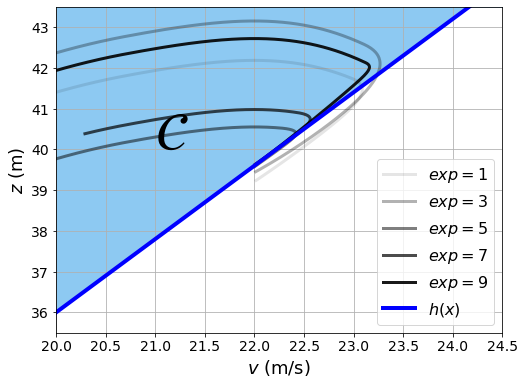

In [18]:
f,ax = plt.subplots(1,1,figsize = (8,6))
t_lns = np.arange(0, 10, dt)

start = 0
exp = 9

#h_perf = np.array(B_perf_lst)[exp,start:]

for exp in range(10):
    if exp % 2 == 0:
        z = np.array(x_lst)[exp,start:,2]# np.array(B_lst)[exp,start:]
        v = np.array(x_lst)[exp,start:,1]
        ax.plot(v, z, 'black', alpha = 0.1 * (exp + 1), linewidth = 3)
        

        
        
ax.grid(True)
#ax.set_title('Safe distance performance vs velocity. $z \geq T_h v$', fontsize= 18)
#ax.legend(['estimated','real'],fontsize= 16) 
ax.set_ylabel('$z$ (m)', fontsize= 18)
ax.set_xlabel('$v$ (m/s)', fontsize= 18)

v_min = 20
v_max = 24.5
z_min = 35.5
z_max = 43.5

v_span = np.linspace(v_min, v_max, 50)
ax.plot(v_span, v_span*Th, 'blue',linewidth = 4 )


ax.legend(['$exp=1$','$exp=3$','$exp=5$','$exp=7$','$exp=9$','$h(x)$'],fontsize= 16) 
plt.gca().fill_between(v_span, v_span*Th, z_max, v_span > 0, color = (0.552, 0.788, 0.949))
ax.set_ylim(z_min, z_max)
ax.set_xlim(v_min, v_max)

ax.text(21,40,'$\mathcal{C}$', fontsize=54)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [ ]:
f,ax = plt.subplots(1,1,figsize = (13,6))
t_lns = np.arange(0, 10, dt)

start = 0

for exp in range(10):
    if exp % 3 == 0:
        h_ = np.array(B_perf_lst)[exp,start:]
        ax.plot(t_lns[start:], h )
        #print(exp)
        
ax.grid(True)
ax.set_title('Barrier function evolution in multiple experiences', fontsize= 18)
ax.legend(['exp 1','exp 4','exp 7','exp 10'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$V(x, u)$', fontsize= 18)

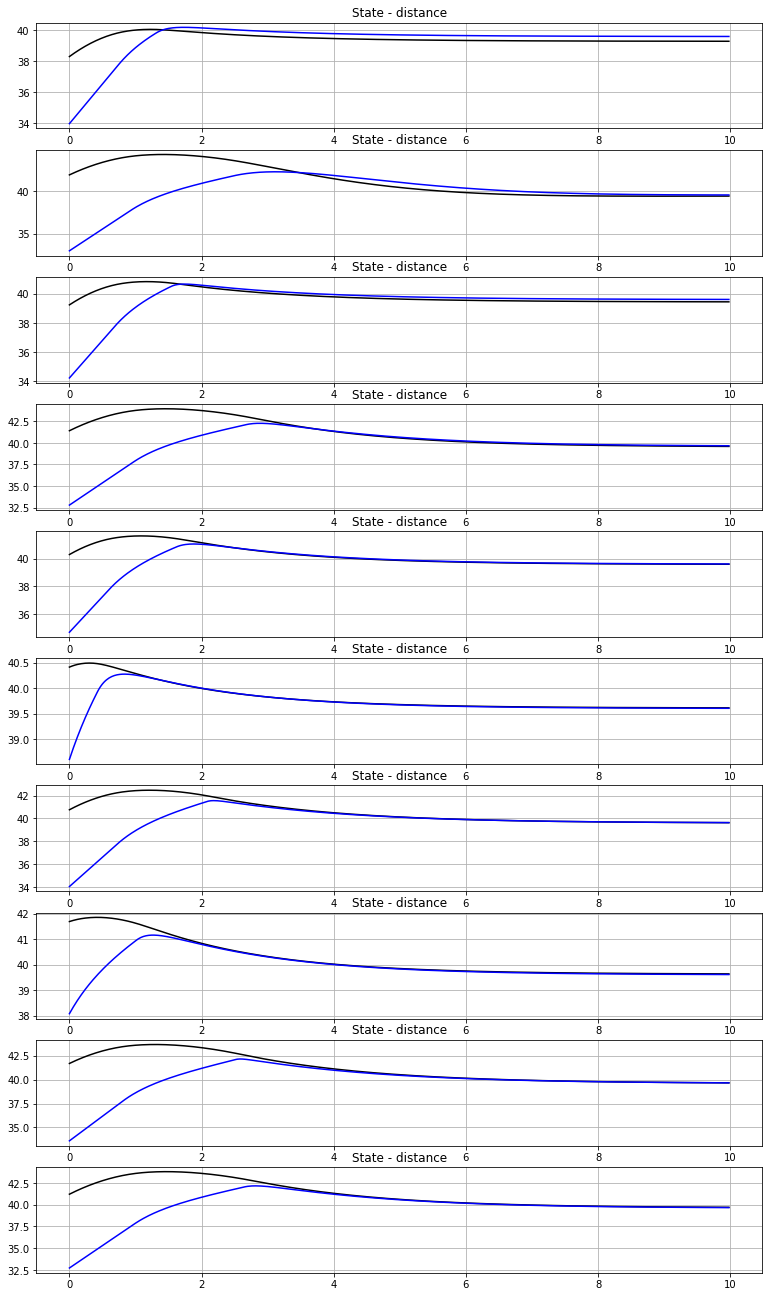

In [73]:
f,ax = plt.subplots(10,1,figsize = (13,23))
t_lns = np.arange(0, 10, dt)

for exp in range(10):
    ax[exp].plot(t_lns, np.array(x_lst)[exp,:,2],'black')
    ax[exp].grid(True)
    ax[exp].set_title('State - distance')

    ax[exp].plot(t_lns, Th*np.array(x_lst)[exp,:,1], 'blue')

### First time

In [ ]:
d = Dataset()
T = 10   # Number of experiences

aac = AAC(m, c_d, f0, f1, f2, v_ego)

cont = LQPCBFCLF(m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_ego, v_des, Th, clf_rate, cbf_rate, p_slack)

A_h = Estimator(3)
A_h_opt = torch.optim.Adam(A_h.model.parameters(), lr = 1e-4)

B_h = Estimator(3)
B_h_opt = torch.optim.Adam(B_h.model.parameters(), lr = 1e-4)


weights = 0.2

x_lst = []
u_lst = []
V_lst = []
B_lst = []
slack_lst = []


a_h_lst = []
b_h_lst = []


for _ in range(T):
    x0 = sample_initial_state()
    x = x0
    derivator = Derivator(dt)
    
    xs = []
    us = []
    Vs = []
    Bs = []
    slacks = []
    b_hs = []
    a_hs = []
    
    # Train
    for t in np.arange(0, simTime, dt): #simTime
        # Get Fr
        v = x[1]
        Fr = f0_nom * v**2 + f1_nom * v + f2_nom

        # Control Input
        a_h, b_h, k, slack_sol, V, B, db_hat = cont.compute_controller(x, Fr, A_h, B_h, weights)

        # One step propagation in the system
        x_n = aac.update(x, k, t, dt)
        
        db = derivator.update(B)
        
        d.update(x, k, db, db_hat)
        
    
    # Test
    x = [0,20,40]
    for t in np.arange(0, simTime, dt): #simTime
        # Get Fr
        v = x[1]
        Fr = f0_nom * v**2 + f1_nom * v + f2_nom

        # Control Input
        a_h, b_h, k, slack_sol, V, B, db_hat = cont.compute_controller(x, Fr, A_h, B_h, weights)

        # One step propagation in the system
        x_n = aac.update(x, k, t, dt)
 
        xs.append(x)
        us.append(k)
        Vs.append(V)
        Bs.append(B)
        slacks.append(slack_sol)
        a_hs.append(a_h)
        b_hs.append(b_h)
        
        x = x_n
        
        
    # Save data
    x_lst.append(xs)
    u_lst.append(us)
    V_lst.append(Vs)
    B_lst.append(Bs)
    slack_lst.append(slacks)
    a_h_lst.append(a_hs)
    b_h_lst.append(b_hs)

    # Train estimator
    sample = d.get_D()
        
    for x_i, k_i, dh_i, dh_hat_i in zip(sample.x, sample.k, sample.dh, sample.dh_hat ):
        S_i = A_h.forward(x_i, train = True) + B_h.forward(x_i, train = True)*k_i + cont.dcbf(x_i, k_i) # dh_hat_i
        
        Loss = F.mse_loss(torch.tensor(dh_i),S_i)

        A_h.model.zero_grad()
        B_h.model.zero_grad()

        Loss.backward()
        A_h_opt.step()
        B_h_opt.step()
    
        
        

